## Data Loading and Preprocessing

In [9]:
from pathlib import Path
import re
import string
import pandas as pd
from sklearn.model_selection import train_test_split


def load_data(path: Path) -> pd.DataFrame:
    data = pd.read_csv(path)
    data = pd.DataFrame(
        {
            "job_description": data[
                ["company_profile", "description", "requirements", "benefits"]
            ]
            .fillna("")
            .agg(" ".join, axis=1),
            "fraudulent": data["fraudulent"],
        }
    )
    data = data.drop_duplicates(subset=["job_description"], keep="first")
    return data

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def split_data(data: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(
        data["job_description"],
        data["fraudulent"],
        test_size=0.2,
        random_state=42,
        stratify=data["fraudulent"],
    )

    # Convert to DataFrame for easy manipulation
    train_df = pd.DataFrame({'job_description': X_train, 'fraudulent': y_train})

    # Separate fraudulent (y=1) and non-fraudulent (y=0) samples
    fraudulent_df = train_df[train_df['fraudulent'] == 1]
    non_fraudulent_df = train_df[train_df['fraudulent'] == 0]
    print(fraudulent_df.shape, non_fraudulent_df.shape)

    # Oversample each fraudulent job description exactly 21 times
    fraudulent_df_oversampled = pd.concat([fraudulent_df] * 21, ignore_index=True)

    # Combine the oversampled fraudulent data with the original non-fraudulent data
    train_df_oversampled = pd.concat([non_fraudulent_df, fraudulent_df_oversampled], ignore_index=True)

    # Shuffle the data
    train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract the oversampled X_train and y_train
    X_train: pd.Series[str] = train_df_oversampled['job_description']
    y_train: pd.Series[int] = train_df_oversampled['fraudulent']

    # apply clean_text function to the training and test data

    X_train = X_train.apply(clean_text)
    X_test = X_test.apply(clean_text)

    return X_train, X_test, y_train, y_test


## Download the Dataset from Kaggle

In [10]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
print("Path to dataset files:", path)

data = load_data(Path(path + "/fake_job_postings.csv"))

X_train, X_test, y_train, y_test = split_data(data)

print(X_train.head())
print(y_train.head())

Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1
(547, 2) (11832, 2)
0     in trading is a vertically integrated solid w...
1    we believe cities are complicated and your mob...
2    smarter good is an innovative global services ...
3    join the your phone connect team and earn mone...
4    at total eclipse we create fun original and ad...
Name: job_description, dtype: object
0    0
1    0
2    0
3    1
4    0
Name: fraudulent, dtype: int64


## Define the Dataset loader

In [11]:
from torch.utils.data import Dataset
import torch

class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        Args:
            texts (pd.Series or list): The job descriptions.
            labels (pd.Series or list): The corresponding labels (0 or 1).
            tokenizer (PreTrainedTokenizer): Tokenizer for BERT.
            max_length (int): Maximum token length for each text.
        """
        # Convert pandas Series to list if needed
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        # Tokenize the text with truncation and padding
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze to remove the batch dimension
        encoding = {key: tensor.squeeze(0) for key, tensor in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return encoding

In [12]:
model = "bert-base-uncased"

In [13]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(model)

train_dataset = JobDataset(X_train, y_train, tokenizer, max_length=512)
test_dataset = JobDataset(X_test, y_test, tokenizer, max_length=512)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
from transformers import BertForSequenceClassification

bert = BertForSequenceClassification.from_pretrained(model, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import Trainer, TrainingArguments
import numpy as np

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',             # output directory
    num_train_epochs=1,                 # total number of training epochs
    per_device_train_batch_size=16,     # batch size per device during training
    per_device_eval_batch_size=16,      # batch size for evaluation
    evaluation_strategy='epoch',        # evaluate at the end of each epoch
    save_strategy='epoch',              # save checkpoint at the end of each epoch
    logging_dir='./logs',               # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,        # load the best model when finished training
    metric_for_best_model="accuracy",   # use accuracy to evaluate the best model
)

# Initialize the Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune the model
trainer.train()

# Optionally, evaluate the model on the test set after training
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.026800,0.104663,0.983845,0.842520,0.781022,0.810606


Evaluation results: {'eval_loss': 0.10466273128986359, 'eval_accuracy': 0.9838449111470113, 'eval_precision': 0.84251968503937, 'eval_recall': 0.781021897810219, 'eval_f1': 0.8106060606060606, 'eval_runtime': 26.2426, 'eval_samples_per_second': 117.938, 'eval_steps_per_second': 7.393, 'epoch': 1.0}


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2958
           1       0.84      0.78      0.81       137

    accuracy                           0.98      3095
   macro avg       0.92      0.89      0.90      3095
weighted avg       0.98      0.98      0.98      3095



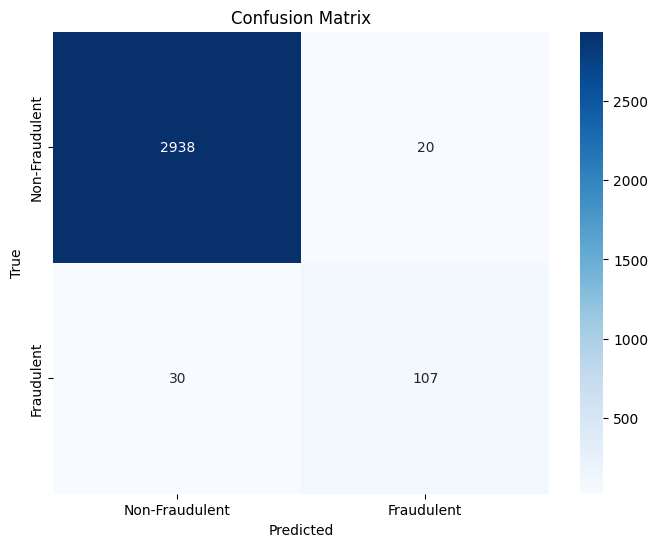

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Evaluate with per-class precision, recall, F1-score
print(classification_report(y_test, predicted_labels))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Save model to Hugging Face

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

repo = "pcloud/job_catcher-bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_bert")

model.push_to_hub(repo)
tokenizer.push_to_hub(repo)

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pcloud/job_catcher-bert-base-uncased/commit/359edfd736108f7494a260a899009ed5e5d60bb4', commit_message='Upload tokenizer', commit_description='', oid='359edfd736108f7494a260a899009ed5e5d60bb4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pcloud/job_catcher-bert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='pcloud/job_catcher-bert-base-uncased'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Replace with your uploaded model name
model_name = repo

# Load model and tokenizer from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

def predict(job_text, model, tokenizer):
    inputs = tokenizer(
        job_text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # 0 = Real, 1 = Fake
    return "Fake Job Posting" if prediction == 1 else "Real Job Posting"

# Example usage:
new_job_posting = "Alliance is looking for people who are passionate about both the work they do and the life they live.We are a high energy, goal oriented organization who is seeking out like minded professionals to assist our organization in continued growth. Alliance is an industry leader in providing innovative point-of-sale (POS) payment acceptance capabilities -- and backing them up with service, financial strength and stability.We offer flexibility, uncapped success, autonomy and life/work balance.You would be hard pressed to find a company that will treat you better. We offer daily/monthly contests and yearly bonuses for top employees. Come see why AMS is one of the fastest growing companies."
result = predict(new_job_posting, model, tokenizer)
result


'Fake Job Posting'